In [2]:
# Install dependencies (for Colab)
!pip install torch==2.0.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric
!pip install pandas scikit-learn matplotlib seaborn
!pip install numpy==1.24.4


Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcu118/torch_scatter-2.1.2%2Bpt20cu118-cp311-cp311-linux_x86_64.whl (10.2 MB)
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 39.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 91.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.

In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import ast


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.0+cu118


In [2]:
class PTGraphDataset(Dataset):
    def __init__(self, pt_file, transform=None):
        self.data_list = torch.load(pt_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        data = self.data_list[idx]
        return self.transform(data) if self.transform else data


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
# Load dataset
train_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/80_20/color_only/train_color_only.pt", weights_only=False)
val_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/80_20/color_only/val_color_only.pt", weights_only=False)
test_data = torch.load("/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/80_20/color_only/test_color_only.pt", weights_only=False)

# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Info jumlah data
print(f"Train: {len(train_data)} data")
print(f"Validasi: {len(val_data)} data")
print(f"Test: {len(test_data)} data")

Train: 15360 data
Validasi: 3840 data
Test: 4800 data


In [13]:
class GATGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=8, dropout=0.6):
        super(GATGraphClassifier, self).__init__()
        self.dropout = dropout

        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, num_classes, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index, batch):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.gat2(x, edge_index)

        # Pooling agar prediksi berada di level graph
        x = global_mean_pool(x, batch)

        return F.log_softmax(x, dim=1)



In [14]:
import random

param_grid = {
    'lr': [0.0001, 0.0005, 0.001],
    'hidden_channels': [64, 128, 256],
    'dropout': [0.0, 0.2, 0.4, 0.6],
    'weight_decay': [1e-5, 1e-4, 5e-4, 1e-3],
    'heads': [1, 2, 4, 8],

}


In [15]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


In [16]:
import matplotlib.pyplot as plt
import os

def train_gat_once(params, train_loader, val_loader, in_channels, num_classes, use_early_stopping=True):
    model = GATGraphClassifier(in_channels=in_channels,
                               hidden_channels=params['hidden_channels'],
                               num_classes=num_classes,
                               heads=params['heads'],
                               dropout=params['dropout']).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.1, 0.917], device=device))

    best_val_loss = float('inf')
    best_val_acc = 0
    best_model_state = None
    epochs_without_improvement = 0
    patience = 15
    max_epochs = 200

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_train_loss = 0
        train_preds, train_labels = [], []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            preds = out.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(labels)

        train_acc = accuracy_score(train_labels, train_preds)
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out, batch.y)
                val_loss += loss.item()
                preds = out.argmax(dim=1).cpu().numpy()
                labels = batch.y.cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if use_early_stopping and epochs_without_improvement >= patience:
            print(f"⛔ Early stopping at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Plot
    plt.figure(figsize=(14, 5))

    # (a) Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='red')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.text(0, -0.02, '(a)', transform=plt.gca().transAxes)

    # (b) Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.text(0, -0.02, '(b)', transform=plt.gca().transAxes)

    plt.tight_layout()

    # Path Google Drive
    save_dir = '/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only'
    os.makedirs(save_dir, exist_ok=True)

    # Gunakan parameter eksperimen untuk nama file
    filename = f"gat_h{params['hidden_channels']}_d{params['dropout']}_lr{params['lr']}_wd{params['weight_decay']}.png"
    save_path = os.path.join(save_dir, filename)

    plt.savefig(save_path)
    print(f"📁 Saved training plot to: {save_path}")
    plt.close()

    return best_val_acc, best_val_loss, model


In [9]:
import random
import numpy as np
import torch
from itertools import product
import pandas as pd
from sklearn.metrics import accuracy_score
import copy
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)

# Cek input channel dari train_loader
for batch in train_loader:
    in_channels = batch.x.shape[1]
    break
else:
    raise ValueError("train_loader kosong, tidak bisa menentukan in_channels")

# === RANDOM SEARCH === #
keys, values = zip(*param_grid.items())
all_possible = list(product(*values))
num_samples = min(20, len(all_possible))
sampled_combinations = random.sample(all_possible, num_samples)
all_combinations = [dict(zip(keys, v)) for v in sampled_combinations]

best_acc = 0
best_params = None
best_model = None
results = []

# Simpanan ke Google Drive
save_dir = '/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only'
os.makedirs(save_dir, exist_ok=True)

for i, params in enumerate(all_combinations):
    print(f"\n🔎 Eksperimen {i+1}/{num_samples}: {params}")

    # Train model dan simpan plot ke folder tujuan
    val_acc, val_loss, model = train_gat_once(
        params,
        train_loader,
        val_loader,
        in_channels,
        num_classes=2,
        use_early_stopping=True
    )

    print(f"➡️ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    results.append({
        'experiment': i + 1,
        'params': params,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model

# === TEST EVALUATION === #
test_acc = evaluate_model(best_model, test_loader)
print("\n✅ Best Accuracy (Val):", best_acc)
print("📌 Best Hyperparameters:", best_params)
print("🧪 Test Accuracy:", test_acc)

# Simpan model terbaik ke folder
model_path = os.path.join(save_dir, "gat_color_only.pth")
torch.save(best_model.state_dict(), model_path)
print(f"💾 Model terbaik disimpan ke '{model_path}'")

# Simpan hasil eksperimen ke CSV
df_results = pd.DataFrame(results)
csv_path = os.path.join(save_dir, "hyperparam_search_results_color_only.csv")
df_results.to_csv(csv_path, index=False)
print(f"💾 Hasil eksperimen disimpan ke '{csv_path}'")



🔎 Eksperimen 1/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.6, 'weight_decay': 1e-05, 'heads': 4}
⛔ Early stopping at epoch 59
📁 Saved training plot to: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only/gat_h128_d0.6_lr0.0001_wd1e-05.png
➡️ Val Accuracy: 0.6174 | Val Loss: 0.6362

🔎 Eksperimen 2/20: {'lr': 0.0001, 'hidden_channels': 64, 'dropout': 0.2, 'weight_decay': 0.0005, 'heads': 2}
📁 Saved training plot to: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only/gat_h64_d0.2_lr0.0001_wd0.0005.png
➡️ Val Accuracy: 0.6859 | Val Loss: 0.5864

🔎 Eksperimen 3/20: {'lr': 0.0005, 'hidden_channels': 128, 'dropout': 0.2, 'weight_decay': 0.0005, 'heads': 2}
⛔ Early stopping at epoch 67
📁 Saved training plot to: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only/gat_h128_d0.2_lr0.0005_wd0.0005.png
➡️ Val Accuracy: 0.6887 | Val Loss: 0.5890

🔎 Eksperimen 4/20: {'lr': 0.0005, 'hidden_channels': 64, 'dropout': 0.6, 'weight_

In [10]:
from sklearn.metrics import classification_report
import os

# === TEST EVALUATION DENGAN CLASSIFICATION REPORT === #
true_labels = []
pred_labels = []

best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        true_labels.extend(labels)
        pred_labels.extend(preds)

# 📊 Cetak laporan performa per kelas
report = classification_report(true_labels, pred_labels, digits=4)
print("\n📋 Classification Report di Test Set:")
print(report)

# 📝 Simpan ke file
save_dir = '/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only'
os.makedirs(save_dir, exist_ok=True)  # Pastikan direktori ada

report_path = os.path.join(save_dir, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write("📋 Classification Report di Test Set:\n")
    f.write(report)

print(f"\n✅ Classification report berhasil disimpan di: {report_path}")



📋 Classification Report di Test Set:
              precision    recall  f1-score   support

           0     0.7312    0.8145    0.7706      1089
           1     0.8298    0.7513    0.7886      1311

    accuracy                         0.7800      2400
   macro avg     0.7805    0.7829    0.7796      2400
weighted avg     0.7851    0.7800    0.7805      2400


✅ Classification report berhasil disimpan di: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only/classification_report.txt



📊 Evaluasi Model pada Data Uji
✅ Accuracy   : 0.7800
✅ F1 Score   : 0.7886
✅ Recall     : 0.7513
✅ Precision  : 0.8298

🧩 Confusion Matrix:
 [[887 202]
 [326 985]]
📄 Laporan evaluasi disimpan ke: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only/test_evaluation_report.txt


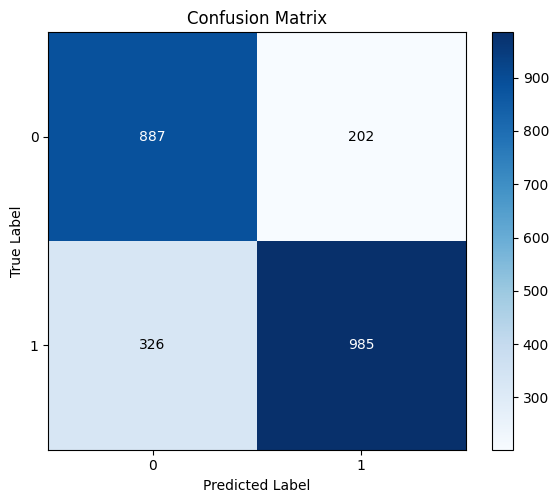

🖼️ Gambar confusion matrix disimpan ke: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only/confusion_matrix_test.png

❌ Jumlah prediksi salah: 528
📄 Log kesalahan disimpan ke: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only/wrong_predictions.csv


In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import csv
import os

# === Folder penyimpanan hasil === #
save_dir = '/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/90_10/color_only'
os.makedirs(save_dir, exist_ok=True)

# === Evaluasi Model Terbaik === #
best_model.eval()
all_preds, all_labels, all_scores, all_file_names = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_scores.extend(probs.tolist())
        all_file_names.extend(file_names)

# === Hitung Metrik === #
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\n📊 Evaluasi Model pada Data Uji")
print("=" * 40)
print(f"✅ Accuracy   : {acc:.4f}")
print(f"✅ F1 Score   : {f1:.4f}")
print(f"✅ Recall     : {recall:.4f}")
print(f"✅ Precision  : {precision:.4f}")
print("\n🧩 Confusion Matrix:\n", cm)
print("=" * 40)

# === Simpan ke File Teks === #
report_path = os.path.join(save_dir, "test_evaluation_report.txt")
with open(report_path, "w") as f:
    f.write("📊 Evaluasi Model pada Data Uji\n")
    f.write("=" * 40 + "\n")
    f.write(f"Accuracy   : {acc:.4f}\n")
    f.write(f"F1 Score   : {f1:.4f}\n")
    f.write(f"Recall     : {recall:.4f}\n")
    f.write(f"Precision  : {precision:.4f}\n")
    f.write("\nConfusion Matrix:\n")
    f.write(str(cm) + "\n")
    f.write("=" * 40 + "\n")
print(f"📄 Laporan evaluasi disimpan ke: {report_path}")

# === Gambar Confusion Matrix === #
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

cm_img_path = os.path.join(save_dir, "confusion_matrix_test.png")
plt.savefig(cm_img_path)
plt.show()
print(f"🖼️ Gambar confusion matrix disimpan ke: {cm_img_path}")

# === Simpan Prediksi yang Salah === #
wrong_preds = []
for fname, pred, label, score in zip(all_file_names, all_preds, all_labels, all_scores):
    if pred != label:
        wrong_preds.append({
            'file_name': fname,
            'true_label': label,
            'predicted_label': pred,
            'score_0': score[0],
            'score_1': score[1],
        })

wrong_log_path = os.path.join(save_dir, "wrong_predictions.csv")
with open(wrong_log_path, mode='w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['file_name', 'true_label', 'predicted_label', 'score_0', 'score_1'])
    writer.writeheader()
    for row in wrong_preds:
        writer.writerow(row)

print(f"\n❌ Jumlah prediksi salah: {len(wrong_preds)}")
print(f"📄 Log kesalahan disimpan ke: {wrong_log_path}")


80_20

In [17]:
import random
import numpy as np
import torch
from itertools import product
import pandas as pd
from sklearn.metrics import accuracy_score
import copy
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)

# Cek input channel dari train_loader
for batch in train_loader:
    in_channels = batch.x.shape[1]
    break
else:
    raise ValueError("train_loader kosong, tidak bisa menentukan in_channels")

# === RANDOM SEARCH === #
keys, values = zip(*param_grid.items())
all_possible = list(product(*values))
num_samples = min(20, len(all_possible))
sampled_combinations = random.sample(all_possible, num_samples)
all_combinations = [dict(zip(keys, v)) for v in sampled_combinations]

best_acc = 0
best_params = None
best_model = None
results = []

# Simpanan ke Google Drive
save_dir = '/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only'
os.makedirs(save_dir, exist_ok=True)

for i, params in enumerate(all_combinations):
    print(f"\n🔎 Eksperimen {i+1}/{num_samples}: {params}")

    # Train model dan simpan plot ke folder tujuan
    val_acc, val_loss, model = train_gat_once(
        params,
        train_loader,
        val_loader,
        in_channels,
        num_classes=2,
        use_early_stopping=True
    )

    print(f"➡️ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    results.append({
        'experiment': i + 1,
        'params': params,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_model = model

# === TEST EVALUATION === #
test_acc = evaluate_model(best_model, test_loader)
print("\n✅ Best Accuracy (Val):", best_acc)
print("📌 Best Hyperparameters:", best_params)
print("🧪 Test Accuracy:", test_acc)

# Simpan model terbaik ke folder
model_path = os.path.join(save_dir, "gat_color_only.pth")
torch.save(best_model.state_dict(), model_path)
print(f"💾 Model terbaik disimpan ke '{model_path}'")

# Simpan hasil eksperimen ke CSV
df_results = pd.DataFrame(results)
csv_path = os.path.join(save_dir, "hyperparam_search_results_color_only.csv")
df_results.to_csv(csv_path, index=False)
print(f"💾 Hasil eksperimen disimpan ke '{csv_path}'")



🔎 Eksperimen 1/20: {'lr': 0.0001, 'hidden_channels': 128, 'dropout': 0.6, 'weight_decay': 1e-05, 'heads': 4}
⛔ Early stopping at epoch 37
📁 Saved training plot to: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only/gat_h128_d0.6_lr0.0001_wd1e-05.png
➡️ Val Accuracy: 0.6107 | Val Loss: 0.6393

🔎 Eksperimen 2/20: {'lr': 0.0001, 'hidden_channels': 64, 'dropout': 0.2, 'weight_decay': 0.0005, 'heads': 2}
⛔ Early stopping at epoch 154
📁 Saved training plot to: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only/gat_h64_d0.2_lr0.0001_wd0.0005.png
➡️ Val Accuracy: 0.6971 | Val Loss: 0.5815

🔎 Eksperimen 3/20: {'lr': 0.0005, 'hidden_channels': 128, 'dropout': 0.2, 'weight_decay': 0.0005, 'heads': 2}
⛔ Early stopping at epoch 72
📁 Saved training plot to: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only/gat_h128_d0.2_lr0.0005_wd0.0005.png
➡️ Val Accuracy: 0.6966 | Val Loss: 0.5788

🔎 Eksperimen 4/20: {'lr': 0.0005, 'hidden_channels'

In [18]:
from sklearn.metrics import classification_report
import os

# === TEST EVALUATION DENGAN CLASSIFICATION REPORT === #
true_labels = []
pred_labels = []

best_model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = batch.y.cpu().numpy()
        true_labels.extend(labels)
        pred_labels.extend(preds)

# 📊 Cetak laporan performa per kelas
report = classification_report(true_labels, pred_labels, digits=4)
print("\n📋 Classification Report di Test Set:")
print(report)

# 📝 Simpan ke file
save_dir = '/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only'
os.makedirs(save_dir, exist_ok=True)  # Pastikan direktori ada

report_path = os.path.join(save_dir, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write("📋 Classification Report di Test Set:\n")
    f.write(report)

print(f"\n✅ Classification report berhasil disimpan di: {report_path}")


📋 Classification Report di Test Set:
              precision    recall  f1-score   support

           0     0.7048    0.7484    0.7259      2150
           1     0.7851    0.7457    0.7649      2650

    accuracy                         0.7469      4800
   macro avg     0.7449    0.7470    0.7454      4800
weighted avg     0.7491    0.7469    0.7474      4800


✅ Classification report berhasil disimpan di: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only/classification_report.txt



📊 Evaluasi Model pada Data Uji
✅ Accuracy   : 0.7469
✅ F1 Score   : 0.7649
✅ Recall     : 0.7457
✅ Precision  : 0.7851

🧩 Confusion Matrix:
 [[1609  541]
 [ 674 1976]]
📄 Laporan evaluasi disimpan ke: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only/test_evaluation_report.txt


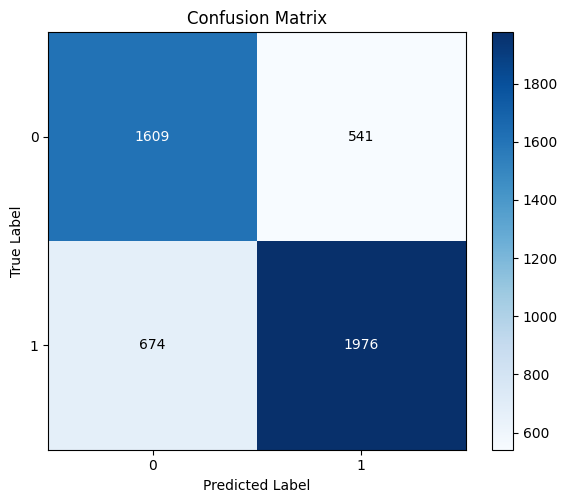

🖼️ Gambar confusion matrix disimpan ke: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only/confusion_matrix_test.png

❌ Jumlah prediksi salah: 1215
📄 Log kesalahan disimpan ke: /content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only/wrong_predictions.csv


In [19]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import csv
import os

# === Folder penyimpanan hasil === #
save_dir = '/content/drive/MyDrive/Hasil_Ekstraksi/Tugas Akhir/GAT/80_20/color_only'
os.makedirs(save_dir, exist_ok=True)

# === Evaluasi Model Terbaik === #
best_model.eval()
all_preds, all_labels, all_scores, all_file_names = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = best_model(batch.x, batch.edge_index, batch.batch)
        probs = F.softmax(out, dim=1).cpu()
        preds = probs.argmax(dim=1)
        labels = batch.y.cpu()

        try:
            data_list = batch.to_data_list()
            file_names = [d.file_name if hasattr(d, 'file_name') else f"G_{i}" for i, d in enumerate(data_list)]
        except:
            file_names = [f"G_{i}" for i in range(len(labels))]

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_scores.extend(probs.tolist())
        all_file_names.extend(file_names)

# === Hitung Metrik === #
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print("\n📊 Evaluasi Model pada Data Uji")
print("=" * 40)
print(f"✅ Accuracy   : {acc:.4f}")
print(f"✅ F1 Score   : {f1:.4f}")
print(f"✅ Recall     : {recall:.4f}")
print(f"✅ Precision  : {precision:.4f}")
print("\n🧩 Confusion Matrix:\n", cm)
print("=" * 40)

# === Simpan ke File Teks === #
report_path = os.path.join(save_dir, "test_evaluation_report.txt")
with open(report_path, "w") as f:
    f.write("📊 Evaluasi Model pada Data Uji\n")
    f.write("=" * 40 + "\n")
    f.write(f"Accuracy   : {acc:.4f}\n")
    f.write(f"F1 Score   : {f1:.4f}\n")
    f.write(f"Recall     : {recall:.4f}\n")
    f.write(f"Precision  : {precision:.4f}\n")
    f.write("\nConfusion Matrix:\n")
    f.write(str(cm) + "\n")
    f.write("=" * 40 + "\n")
print(f"📄 Laporan evaluasi disimpan ke: {report_path}")

# === Gambar Confusion Matrix === #
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

cm_img_path = os.path.join(save_dir, "confusion_matrix_test.png")
plt.savefig(cm_img_path)
plt.show()
print(f"🖼️ Gambar confusion matrix disimpan ke: {cm_img_path}")

# === Simpan Prediksi yang Salah === #
wrong_preds = []
for fname, pred, label, score in zip(all_file_names, all_preds, all_labels, all_scores):
    if pred != label:
        wrong_preds.append({
            'file_name': fname,
            'true_label': label,
            'predicted_label': pred,
            'score_0': score[0],
            'score_1': score[1],
        })

wrong_log_path = os.path.join(save_dir, "wrong_predictions.csv")
with open(wrong_log_path, mode='w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['file_name', 'true_label', 'predicted_label', 'score_0', 'score_1'])
    writer.writeheader()
    for row in wrong_preds:
        writer.writerow(row)

print(f"\n❌ Jumlah prediksi salah: {len(wrong_preds)}")
print(f"📄 Log kesalahan disimpan ke: {wrong_log_path}")
